# Fitting photometry and spectra together

Usage example for the procedure PPXF, which implements the
 Penalized Pixel-Fitting (pPXF) method originally described in
 [Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C)
 and upgraded in [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C)

 MODIFICATION HISTORY:
   V1.0.0: Written
       Michele Cappellari, Oxford, 13 March 2022


In [1]:
from os import path

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib

ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

add_noise = True
phot_fit = True

## Read the observed galaxy spectrum

Read SDSS DR8 galaxy spectrum taken from here http://www.sdss3.org/dr8/
The spectrum is *already* log rebinned by the SDSS DR8
pipeline and log_rebin should not be used in this case.

In [2]:
file = ppxf_dir + '/spectra/NGC3073_SDSS_DR8.fits'
hdu = fits.open(file)
t = hdu[1].data
z = float(hdu[1].header["Z"]) # SDSS redshift estimate

Only use the wavelength range in common between galaxy and stellar library

In [3]:
mask = (t['wavelength'] > 3540) & (t['wavelength'] < 7409)
flux = t['flux'][mask]
galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
wave = t['wavelength'][mask]

The SDSS wavelengths are in vacuum, while the MILES ones are in air. For a rigorous treatment, the SDSS vacuum wavelengths should be converted into air wavelengths and the spectra should be resampled. To avoid resampling, given that the wavelength dependence of the correction is very weak, I approximate it with a constant factor.


In [4]:
wave *= np.median(util.vac_to_air(wave)/wave)
rms = 0.019  # rms scatter of the spectrum residuals
goodpixels = np.arange(galaxy.size)  # fit full spectrum

In a real situation one does not know the galaxy spectrum outside
the fitted range. However, in this example I pass the full galaxy
spectrum to pPXF even tough fit only a limited range of goodpixels.
In this way I can see directly how well the extrapolated best fit
reproduces the true galaxy spectrum outside the fitted range.


In [5]:
if add_noise:
    goodpixels = np.arange(1000, 1500)  # Select Hbeta + Mgb
    rms = 0.05     # rms scatter of the spectrum residuals
    np.random.seed(8)  # fixed seed for reproduciible results
    galaxy = np.random.normal(galaxy, rms)

In [6]:
noise = np.full_like(galaxy, rms)

Estimate the wavelength fitted range in the rest frame.
This is used to select the gas templates falling in the fitted range

In [7]:
wave_good = wave[goodpixels]
lam_range_gal = np.array([np.min(wave_good), np.max(wave_good)])/(1 + z)

## Observed galaxy photometric fluxes

Mean galaxy fluxes in the photometric bands `[u, g, r, i, J, H, K]`.
They are normalized like the galaxy spectrum

In [8]:
phot_galaxy = [0.654, 1.08, 0.928, 0.795, 0.473, 0.306, 0.141]   # fluxes
phot_noise = np.full_like(phot_galaxy, 0.01)   # 1sigma uncertainties

## Setup spectral templates

The velocity step was already chosen by the SDSS pipeline and I convert it below to km/s

In [9]:
c = 299792.458  # speed of light in km/s
velscale = c*np.log(wave[1]/wave[0])  # eq.(8) of Cappellari (2017)
FWHM_gal = 2.76  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

The templates are normalized to the V-band using norm_range. In this way
the weights returned by pPXF represent V-band light fractions of each SSP.

In [10]:
pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'
miles = lib.miles(pathname, velscale, FWHM_gal, norm_range=[5070, 5950])

The stellar templates are reshaped below into a 2-dim array with each
spectrum as a column, however we save the original array dimensions,
which are needed to specify the regularization dimensions

In [11]:
reg_dim = miles.templates.shape[1:]
stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

Construct a set of Gaussian emission line templates.
The `emission_lines` function defines the most common lines, but additional
lines can be included by editing the function in the file `ppxf_util.py`.

In [12]:
gas_templates, gas_names, line_wave = util.emission_lines(
    miles.ln_lam_temp, lam_range_gal, FWHM_gal)

Emission lines included in gas templates:
['Hbeta' '[OIII]5007_d']


Combines the stellar and gaseous templates into a single array. During
the pPXF fit they will be assigned a different kinematic COMPONENT value

In [13]:
templates = np.column_stack([stars_templates, gas_templates])

## Setup photometric templates

In [14]:
if phot_fit:
    bands = ['u', 'g', 'r', 'i', 'J', 'H', 'K']
    phot_templates = np.empty((len(bands), miles.n_ages, miles.n_metal))
    phot_lam = np.empty(len(bands))
    for j, band in enumerate(bands):
        phot_lam[j], phot_templates[j] = miles.photometry(band)
    phot = {"templates": phot_templates, "galaxy": phot_galaxy, "noise": phot_noise, "lam": phot_lam}
else:
    phot = {}

## setting pPXF parameters

The galaxy and the template spectra do not have the same starting wavelength.
For this reason an extra velocity shift DV has to be applied to the template
to fit the galaxy spectrum. We remove this artificial shift by using the
keyword `vsyst` in the call to `pPXF` below, so that all velocities are
measured with respect to `dv`. In this way, the output velocity from `pPXF`
is the proper one related to redshift via eq.(8) of [Cappellari (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C/abstract).

In [15]:
c = 299792.458
dv = c*(miles.ln_lam_temp[0] - np.log(wave[0]))  # eq.(8) of Cappellari (2017)
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 180.]     # (km/s), starting guess for [V, sigma]

I fit two kinematics components, one for the stars and one for the gas.
Assign `component=0` to the stellar templates, `component=1` to the gas.

In [16]:
n_stars = stars_templates.shape[1]
n_gas = len(gas_names)
component = [0]*n_stars + [1]*n_gas
gas_component = np.array(component) > 0  # gas_component=True for gas templates

Fit (V, sig) moments=2 for both the stars and the gas

In [17]:
moments = [2, 2]

Adopt the same starting value for both the stars and the gas components

In [18]:
start = [start, start]

## Start pPXF fit

In [19]:
pp = ppxf(templates, galaxy, noise, velscale, start,
          moments=moments, degree=-1, mdegree=-1, vsyst=dv, lam=wave, regul=1/rms, 
          reg_dim=reg_dim, component=component, gas_component=gas_component, reddening=0, 
          gas_names=gas_names, goodpixels=goodpixels, phot=phot)

 Best Fit:       Vel     sigma
 comp.  0:      1161        49
 comp.  1:      1148         1
Stars Reddening E(B-V): 0.152
chi2/DOF: 1.132; degree = -1; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  77 / 152
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                 Hbeta      1.100     0.098    1148     1
Comp:  1          [OIII]5007_d      1.159      0.12    1148     1
-----------------------------------------------------------------


In [20]:
light_weights = pp.weights[~gas_component]      # Exclude weights of the gas templates
light_weights = light_weights.reshape(reg_dim)  # Reshape to (n_ages, n_metal)
light_weights /= light_weights.sum()            # Normalize to light fractions

Given that the templates are normalized to the V-band, the `pPXF` weights
represent V-band light fractions and the computed ages and metallicities
below are also light weighted in the V-band.

In [21]:
miles.mean_age_metal(light_weights)

Weighted <lg_age> [yr]: 8.72
Weighted <[M/H]>: -0.577


(8.723139126399218, -0.5774343058110121)

For the M/L one needs to input fractional masses, not light fractions.
For this, I convert light-fractions into mass-fractions using miles.flux

In [22]:
mass_weights = light_weights/miles.flux
mass_weights /= mass_weights.sum()              # Normalize to mass fractions
miles.mass_to_light(mass_weights, band="r")

M/L_r: 0.5870


0.5870213935230819

## Plot fit results for stars, gas and stellar population

In [23]:
#%matplotlib widget

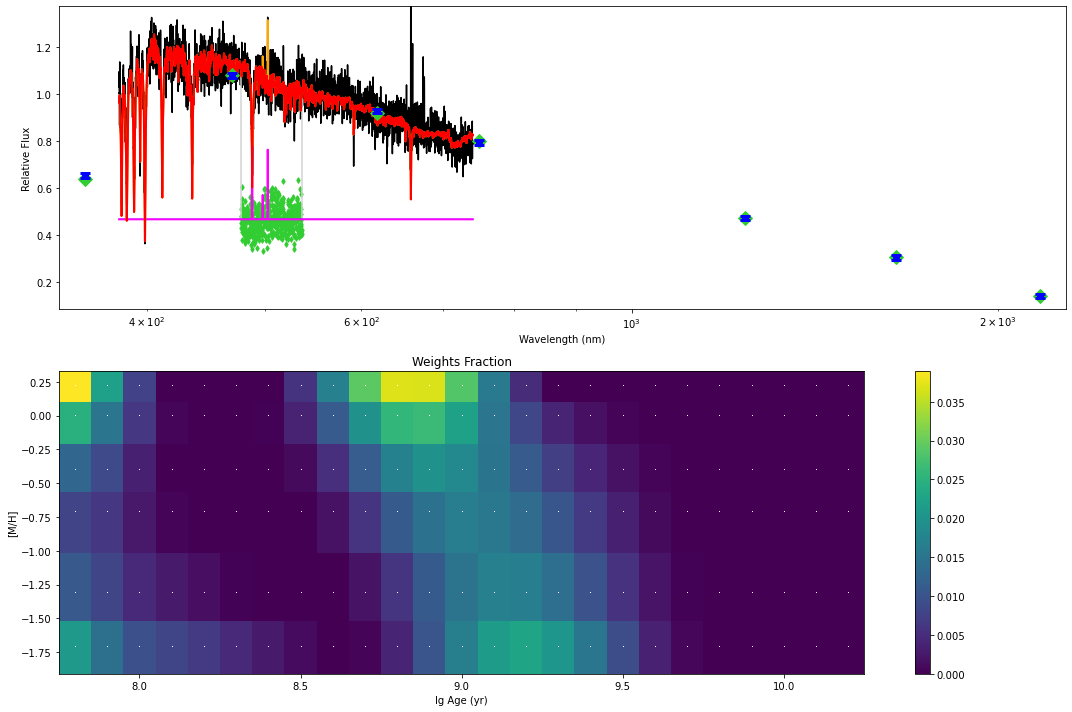

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(211)
pp.plot()
plt.subplot(212)
miles.plot(light_weights)
plt.tight_layout()

In [25]:
%load_ext watermark

In [27]:
%watermark -v -m -p numpy,matplotlib,ppxf,astropy

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.1.1

numpy     : 1.21.5
matplotlib: 3.5.1
ppxf      : 7.4.5
astropy   : 5.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit

